## Cartesian sampling using continuous normalized frequencies 
We're generating the sampling schemes in the continuous Fourier domain. So we no longer stick to the grid
and manipulte continuous frequencies as a list of 2D coordinate points $(k_x,k_y)$.
* Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
* Date: 04/02/2019
* Target: ISBI'19 tutorial on Recent advances in acquisition and reconstruction for Compressed Sensing MRI

<IPython.core.display.Javascript object>


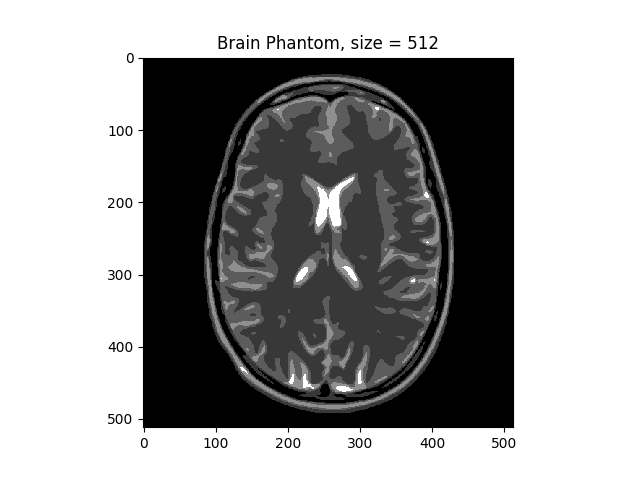

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, img_as_float, io, filters
from skimage.measure import compare_ssim as ssim

#get current working dir

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"..","data")
img_size = 512   #256
FOV = 0.2 #field of view parameter in m (ie real FOV = 20 x20 cm^2)
pixel_size = FOV / img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom%s.png" % img_size
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

In [2]:
#PARAMETERS AND CONSTRAINTS
from collections import namedtuple

SamplingOptions = namedtuple("SamplingOptions", "nc ns OS_factor decim tau decay mask iter init Kmax Smax Gmax gamma dTime n_revol n_epi")

#Kmax depends of FOV and image resolution (NS criterion)
#Gmax and Smax : maximum gradient (T/m) and slew rate (T/m/ms)
#tau, decay and mask parametrize the sampling density (mask=1 for circular - isotrope kspace - 0 otherwise)
#iter = number of iterations (gradient descent steps?)
#mask = initialization for SPARKLING (radial in-out, radial center-out, spiral in-out...)
#gamma = gyromagnetic constant (Hz/T)

sampling_options = SamplingOptions(
    nc=35, #nc is the number of shots in the k-space
    ns=3073, #ns is the number of gradient samples per shot
    OS_factor=1, #Oversampling factor = (gradient raster time)/(gradient dwell time)
    decim=64, # decimation factor 

    decay=2., # decay of the target radial sampling density
    tau=0.75, # threshold for setting the plateau around k=0: 1/(nb per sample/k-space pixel)

    mask=1,            # 1=isotropic, 0=square
    iter=300,          # nb of iterations in the optim algorithm for Sparkling

    Kmax=img_size / (2 * FOV), # Max sampling frequency in m^{-1}: same along k_x, k_y
    Gmax=40e-3,            # hardware constraint on Gmax (gradient magnitude) in mT/m
    Smax=200e-3,           # hardware constraint on Smax (slew rate) in mT/m/ms

    gamma=42.576e3,  #gyro-magnetic ratio en kHz/T
    dTime=0.010,     # dwellTime in ms
    init=None,
    n_revol=None,
    n_epi=None
)
    #samplingOptions.n_revol = 1

In [3]:
#CALCULATED VALUES

alpha = sampling_options.gamma * sampling_options.Gmax
beta = sampling_options.gamma * sampling_options.Smax

cst_ = 1./(2*np.pi)
alpha_R = alpha / sampling_options.Kmax * cst_
beta_R = beta / sampling_options.Kmax * cst_

ns_shot  = 2 * sampling_options.ns // 2 + 1 # odd number of samples for decimation

ns_shot_decim = math.ceil(ns_shot / sampling_options.decim) # number of shots per decimation step

print("ns_shot_decim = %s" % ns_shot_decim)

Dk0_R = 2 * pixel_size / FOV * 1. / (2. * np.pi) #divide by Kmax*2pi

eps = sys.float_info.epsilon
#print("epsilon = " + str(eps))

#Criterium (iii), eq (3.4) C.Lazarus PhD thesis
alpha_R = min(Dk0_R / (sampling_options.dTime * sampling_options.OS_factor), alpha_R)

#UNDERSAMPLING FACTOR
#UF = np.power(img_size,2)/(samplingOptions.nc*samplingOptions.ns) #R in C.Lazarus phd 3.3.2
us_fct = img_size**2 / (sampling_options.nc * sampling_options.ns) #R in C.Lazarus phd 3.3.2

#ACCELERATION RATA
#AF = img_size/samplingOptions.nc
accel_fct = img_size / sampling_options.nc

print("Undersampling factor = %d " %  us_fct)
print("Acceleration factor = %d" % accel_fct)

ns_shot_decim = 49
Undersampling factor = 2 
Acceleration factor = 14


In [4]:
print("Initialization for Cartesian")

k_TE = []
k_TE_decim = []
        
shot_c = np.arange(1, img_size, dtype=np.complex_)

himg_size = math.ceil(img_size / 2.)
shot_c= (-shot_c / (himg_size - 1))
shot_c+=  himg_size / (himg_size - 1)
shot_c = shot_c * cst_
shot = np.array([], dtype=np.complex_)

vec_phase = shot_c * 2. * np.pi
#print(vec_Phase)

for k in vec_phase:
    shotPhase =  shot_c + 1j * cst_ * k*np.ones(len(shot_c))
    shot = np.append(shot, shotPhase)

Initialization for Cartesian


<IPython.core.display.Javascript object>


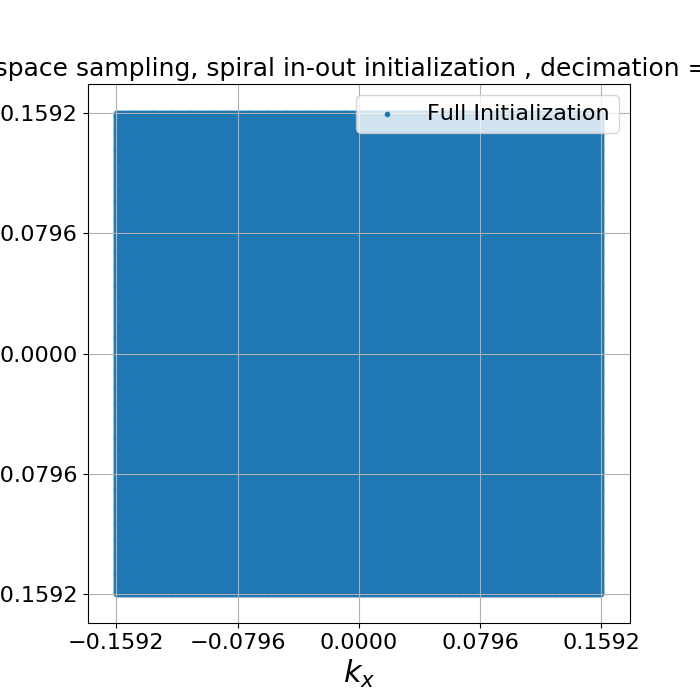

In [5]:
## PLOT SAMPLING SCHEME

k_vec = np.zeros((len(shot), 2))
k_vec[:, 0] = shot.real
k_vec[:, 1] = shot.imag

#Plot full initialization
kspace = plt.figure(figsize=(7, 7))

plt.scatter(k_vec[:, 0], k_vec[:, 1], marker='.', label="Full Initialization")

#axes = plt.gca() 
plt.grid()

# Figure layout
unit = 1. / 4.
tick = np.arange(-0.5, 0.5 + unit, unit)
label = [r"$-\frac{1}{2\pi}$", r"$-\frac{1}{4\pi}$", r"$0$", r"$+\frac{1}{4\pi}$",  r"$+\frac{1}{2\pi}$"]
plt.xticks(tick / np.pi, label=label, fontsize=16)
plt.yticks(tick / np.pi, label=label, fontsize=16)
plt.xlabel(r"$k_x$", fontsize=22)
plt.ylabel(r"$k_y$", fontsize=22)
plt.title("K-space sampling, spiral in-out initialization , decimation = %s" % sampling_options.decim,
          fontsize=18)
plt.legend(fontsize=16)
plt.show()

setting image dimension Nd... (512, 512)
setting spectrum dimension Kd... (512, 512)
setting interpolation size Jd... (6, 6)


<IPython.core.display.Javascript object>


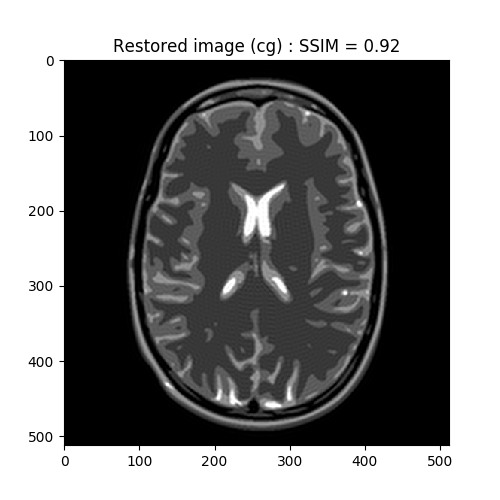

setting non-uniform data
y is an (M,) list <class 'numpy.ndarray'> (261121,)


In [8]:
#from pynfft.nfft import NFFT
import scipy.misc
import matplotlib.pyplot 
from pynufft import NUFFT_cpu
from skimage.measure import compare_ssim as ssim

NufftObj = NUFFT_cpu()
Nd = (img_size, img_size)  # image size
print('setting image dimension Nd...', Nd)
Kd = (img_size, img_size)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

NufftObj.plan(k_vec * 2. * np.pi, Nd, Kd, Jd)

mri_img = mri_img * 1.0 / np.max(mri_img) #image normalization

recons = plt.figure(figsize=(5,5))
kspace_data = NufftObj.forward(mri_img)
print('setting non-uniform data')
print('y is an (M,) list', type(kspace_data), kspace_data.shape)

#image0 = NufftObj.solve(y, solver='cg',maxiter=50)
img_rec0 = NufftObj.solve(kspace_data, solver='cg', maxiter=1e2)
#SSIM
ssim_rec0 = ssim(np.abs(mri_img), np.abs(img_rec0), data_range=mri_img.max() - img_rec0.min())
ssim_rec0 = float(round(abs(ssim_rec0), 3))

plt.title('Restored image (cg) : SSIM = ' + str(ssim_rec0))
plt.imshow(img_rec0.real, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

numpy          : >=1.11.0  - required | 1.16.2    installed
nibabel        : >=2.1.0   - required | 2.4.0     installed
scipy          : >=1.0.0   - required | 1.2.1     installed
modopt         : >=1.1.5   - required | 1.3.0     installed
scikit-learn   : >=0.19.1  - required | ?         installed
astropy        : ==2.0.8   - required | 2.0.8     installed
progressbar    : >=3.34.3  - required | 3.39.3    installed
matplotlib     : >=2.1.2   - required | 3.0.3     installed
pyqtgraph      : >=0.10.0  - requi

/home/pc174679/.local/lib/python3.5/site-packages/pysap/plugins/mri/reconstruct/fourier.py:172: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/pc174679/.local/lib/python3.5/site-packages/pysap/plugins/mri/reconstruct/utils.py:103: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")
100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


<IPython.core.display.Javascript object>


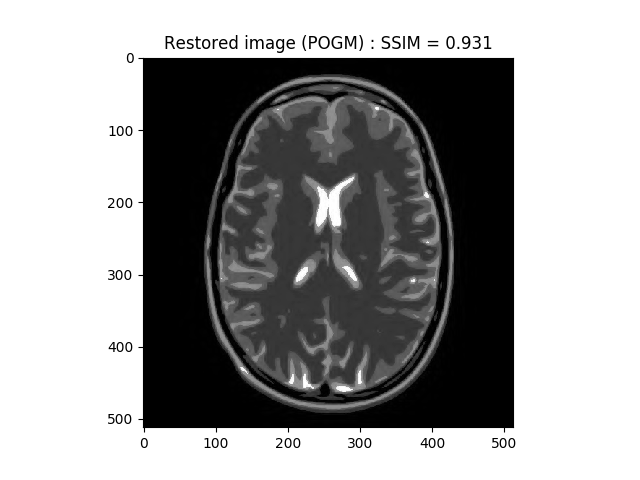

In [7]:
# fista rec using PySAP (branch pogm_addition: https://github.com/zaccharieramzi/pysap/tree/pogm_addition)

from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx
from pysap.numerics.fourier import NFFT
from pysap import Image
from pysap.numerics.gradient import GradAnalysis2
from pysap.numerics.linear import Wavelet2
from pysap.numerics.reconstruct import sparse_rec_pogm
from pysap.numerics.utils import convert_mask_to_locations

## ops init
kspace_loc = convert_mask_to_locations(k_vec)
linear_op = Wavelet2(
    nb_scale=4,
    wavelet_name="Db4",
    padding_mode="periodization",
)

fourier_op = NFFT(
    samples= k_vec * np.pi,
    shape= mri_img.shape,
)

##compute the kspace data
kspace_data_nfft = fourier_op.op(mri_img)

## now back to ops
gradient_op = GradAnalysis2(
    data=kspace_data_nfft,
    fourier_op=fourier_op,
)

# define the proximity operator
prox_op = LinearCompositionProx(
    linear_op=linear_op,
    prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
)

if 1:
    ## run pogm' (ie POGM with restart)
    x_final, metrics = sparse_rec_pogm(prox_op=prox_op, gradient_op=gradient_op, im_shape=mri_img.shape,
                                   mu=0.05, max_iter=100, xi_restart=0.96, metrics_={}, metric_call_period=20)

pogm_rec = np.abs(x_final)
img_rec = Image(data=pogm_rec)
#img_rec.show()
#img_rec = np.abs(x_final)
#print(metrics)
#SSIM

ssim_pogm = ssim(mri_img, pogm_rec,data_range=mri_img.max() - pogm_rec.min())
ssim_pogm = float(round(abs(ssim_pogm),3))

plt.figure()
plt.title('Restored image (POGM) : SSIM = ' + str(ssim_pogm))
plt.imshow(pogm_rec, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))
plt.show()